In [2]:
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy import text, inspect, MetaData

import numpy as np
from pathlib import Path
import pandas as pd
from itertools import product
import datetime as dt

import nxviz as nv
import networkx as nx
from nxviz import layouts, plots, lines
from nxviz import nodes, edges, annotate, highlights
from nxviz.plots import despine, rescale, respine, aspect_equal

from nxviz.utils import edge_table, node_table
from nxviz import encodings as aes

import matplotlib
import matplotlib.pyplot as plt

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Arial"]

c:\Users\higor.monteiro\AppData\Local\anaconda3\envs\sevig310\lib\site-packages\nxviz\__init__.py:18: UserWarning: 
nxviz has a new API! Version 0.7.4 onwards, the old class-based API is being
deprecated in favour of a new API focused on advancing a grammar of network
graphics. If your plotting code depends on the old API, please consider
pinning nxviz at version 0.7.4, as the new API will break your old code.

To check out the new API, please head over to the docs at
https://ericmjl.github.io/nxviz/ to learn more. We hope you enjoy using it!

(This deprecation message will go away in version 1.0.)

  warnings.warn(


## **Definitions**

**Database query**

In [6]:
# -- test
def query_metadata(engine):
    inspector = inspect(engine)
    tables = inspector.get_table_names()
    table_dict = { table_name : inspector.get_columns(table_name) for table_name in tables }
    return table_dict


def query_data(query_str, engine, batchsize=1000):

    schema_data = {
        'rows': [],
        'columns': [],
    }

    query_str = text(query_str)
    with engine.connect() as conn:
        qres = conn.execute(query_str)
        schema_data['columns'] = list(qres.keys())

        while True:
            rows = qres.fetchmany(batchsize)
            if not rows:
                break
            schema_data["rows"] += [ row for row in rows ]
    
    res_df = pd.DataFrame(schema_data['rows'], columns=schema_data['columns'])
    return res_df

**Network definition**

In [63]:
#def format_column(sim_df, col):
#    subset_df = sim_df[[col]].copy()
#    subset_lst = subset_df.apply(lambda x: list(x), axis=1).tolist()
#    formatted_rows = []
#    for current_list in subset_lst:
#        new_el = []
#        for element in current_list:
#            if pd.notna(element):
#                cur = [ el for el in element.strip().split("*") if el!='' ]
#                new_el += cur
#        formatted_rows.append([ el[:3] for el in  new_el ] )
#    formatted_rows = [ elem for elem in formatted_rows if elem ]
#    return formatted_rows

def format_column(sim_df, cols=["CAUSABAS", "LINHAII"]):
    subset_df = sim_df[cols].copy()
    subset_lst = subset_df.apply(lambda x: list(x), axis=1).tolist()
    formatted_rows = []
    for current_list in subset_lst:
        new_el = []
        for element in current_list:
            if pd.notna(element):
                cur = [ el for el in element.strip().split("*") if el!='' ]
                new_el += cur
        formatted_rows.append([ el[:3] for el in  new_el ] )
    formatted_rows = [ elem for elem in formatted_rows if elem ]
    return formatted_rows

def define_edgelist(sim_df, cols=["CAUSABAS", "LINHAII"]):
    '''

    '''
    formatted_rows = format_column(sim_df, cols)
    # -- create list of pairs (order not relevant)
    list_of_pairs = []
    for curr in formatted_rows:
        pairs = list(set(tuple(sorted(t)) for t in product(curr, curr) if t[0] != t[1]))
        list_of_pairs += pairs

    edgelist = pd.Series(list_of_pairs).value_counts().reset_index()
    edgelist['source'] = edgelist['index'].apply(lambda x: x[0])
    edgelist['target'] = edgelist['index'].apply(lambda x: x[1])
    edgelist = edgelist.drop('index', axis=1)
    return edgelist

def define_bipartite_edgelist(sim_df, cols=["CAUSABAS", "LINHAII"]):
    '''
    
    '''
    formatted_rows = format_column(sim_df, cols)
    list_of_pairs = []
    for curr in formatted_rows:
        causabas = curr[0]
        for linha2 in curr[1:]:
            list_of_pairs.append((causabas, linha2))

    edgelist = pd.Series(list_of_pairs).value_counts().reset_index()
    edgelist['source'] = edgelist['index'].apply(lambda x: x[0])
    edgelist['target'] = edgelist['index'].apply(lambda x: x[1])
    edgelist = edgelist.drop('index', axis=1)
    return edgelist

def create_network(edgelist, cutoff=0):
    edgelist1 = edgelist[edgelist['count']>cutoff]

    nodenames = edgelist1['source'].unique().tolist() + edgelist1['target'].unique().tolist()
    nodenames = list(set(nodenames))
    nodelabels = { nodenames[label]: label for label in range(len(nodenames)) }
    
    node_metadata = []
    for label, node in enumerate(nodenames):
        node_metadata.append((
            label, { 'cid10': nodenames[label] }
        ))
    
    edge_metadata = []
    for edge, row in edgelist1.iterrows():
        edge_metadata.append(
            (nodelabels[row['source']], nodelabels[row['target']], {'count': row['count']})
        )
    
    graph = nx.Graph()
    
    graph.add_nodes_from(node_metadata)
    graph.add_edges_from(edge_metadata)
    return graph

def create_bipartite_network(edgelist, cutoff=0):
    '''
    
    '''
    edgelist1 = edgelist[edgelist['count']>cutoff]
    edgelist1["source"] = edgelist1['source'].apply(lambda x: x+'S')
    edgelist1["target"] = edgelist1['target'].apply(lambda x: x+'T')

    nodenames = edgelist1['source'].unique().tolist() + edgelist1['target'].unique().tolist()
    nodenames = list(set(nodenames))
    nodelabels = { nodenames[label]: label for label in range(len(nodenames)) }
    
    node_metadata = []
    for label, node in enumerate(nodenames):
        node_metadata.append((
            label, { 'cid10': nodenames[label][:3], 'type': nodenames[label][-1]  }
        ))
    
    edge_metadata = []
    for edge, row in edgelist1.iterrows():
        edge_metadata.append(
            (nodelabels[row['source']], nodelabels[row['target']], {'count': row['count']})
        )
    
    graph = nx.Graph()
    
    graph.add_nodes_from(node_metadata)
    graph.add_edges_from(edge_metadata)
    return graph

## **Tests**

In [17]:
basefolder = Path.home().joinpath("Documents", "data", "opendatasus")
dbname = "SIM_WAREHOUSE.db"
engine = create_engine(f'sqlite:///'+str(basefolder.joinpath(dbname)))

In [18]:
# --> teste
query_str = f'''
    SELECT * FROM sim LIMIT 5
'''

df = query_data(query_str, engine)
print(df.columns)
print(df.info())
df.head(3)

Index(['CHAVE_CONTADOR_FONTE', 'TIPOBITO', 'DTOBITO', 'NATURAL', 'DTNASC',
       'IDADE', 'SEXO', 'RACACOR', 'ESTCIV', 'ESC', 'OCUP', 'CODMUNRES',
       'LOCOCOR', 'CODMUNOCOR', 'IDADEMAE', 'ESCMAE', 'OCUPMAE', 'QTDFILVIVO',
       'QTDFILMORT', 'GRAVIDEZ', 'GESTACAO', 'PARTO', 'OBITOPARTO', 'PESO',
       'OBITOGRAV', 'OBITOPUERP', 'ASSISTMED', 'EXAME', 'CIRURGIA',
       'NECROPSIA', 'CAUSABAS', 'LINHAA', 'LINHAB', 'LINHAC', 'LINHAD',
       'LINHAII', 'CIRCOBITO', 'ACIDTRAB', 'FONTE_DADOS'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   CHAVE_CONTADOR_FONTE  5 non-null      object
 1   TIPOBITO              5 non-null      object
 2   DTOBITO               5 non-null      object
 3   NATURAL               5 non-null      object
 4   DTNASC                5 non-null      object
 5   IDADE               

,CHAVE_CONTADOR_FONTE,TIPOBITO,DTOBITO,NATURAL,DTNASC,IDADE,SEXO,RACACOR,ESTCIV,ESC,...,NECROPSIA,CAUSABAS,LINHAA,LINHAB,LINHAC,LINHAD,LINHAII,CIRCOBITO,ACIDTRAB,FONTE_DADOS
0,1DOAC2000,2,2000-03-23 00:00:00.000000,812,1976-09-11 00:00:00.000000,423,2,1,1,3,...,None,V892,*T794,*T07X,*V892,None,None,1,2,DOAC2000
1,2DOAC2000,2,2000-03-25 00:00:00.000000,812,1999-10-14 00:00:00.000000,305,2,None,1,1,...,None,R95,*R69X,None,None,None,*R69X,None,None,DOAC2000
2,3DOAC2000,2,2000-02-25 00:00:00.000000,812,2000-02-18 00:00:00.000000,207,1,1,None,None,...,None,R98,*R98X,None,None,None,None,None,None,DOAC2000


In [39]:
sim_query = lambda year: f''' SELECT 
        CHAVE_CONTADOR_FONTE, CODMUNRES, DTOBITO, 
        SUBSTR(CAUSABAS, 1, 3) AS CAUSABAS, LINHAII
    FROM
        sim
    WHERE DTOBITO >= '{year}-01-01' AND DTOBITO <= '{year}-12-31' 
    AND LINHAII IS NOT NULL'''

df = []
for year in range(2010, 2011):
    q = sim_query(year)
    cur_df = query_data(q, engine)
    df.append(cur_df)
df = pd.concat(df)

In [64]:
exl = define_bipartite_edgelist(df, cols=["CAUSABAS", "LINHAII"])
g = create_bipartite_network(exl)

In [66]:
for v in g.nodes():
    print(g.nodes[v], v)
    

{'cid10': 'T88', 'type': 'T'} 0
{'cid10': 'P60', 'type': 'T'} 1
{'cid10': 'H70', 'type': 'S'} 2
{'cid10': 'F19', 'type': 'T'} 3
{'cid10': 'Y58', 'type': 'T'} 4
{'cid10': 'N95', 'type': 'T'} 5
{'cid10': 'W01', 'type': 'T'} 6
{'cid10': 'S38', 'type': 'T'} 7
{'cid10': 'J64', 'type': 'S'} 8
{'cid10': 'N14', 'type': 'T'} 9
{'cid10': 'G40', 'type': 'T'} 10
{'cid10': 'S81', 'type': 'T'} 11
{'cid10': 'L59', 'type': 'T'} 12
{'cid10': 'X20', 'type': 'S'} 13
{'cid10': 'F64', 'type': 'T'} 14
{'cid10': 'I74', 'type': 'T'} 15
{'cid10': 'P58', 'type': 'S'} 16
{'cid10': 'H11', 'type': 'T'} 17
{'cid10': 'I92', 'type': 'T'} 18
{'cid10': 'X35', 'type': 'T'} 19
{'cid10': 'A42', 'type': 'S'} 20
{'cid10': 'D10', 'type': 'T'} 21
{'cid10': 'S85', 'type': 'T'} 22
{'cid10': 'N17', 'type': 'S'} 23
{'cid10': 'V26', 'type': 'S'} 24
{'cid10': 'P70', 'type': 'T'} 25
{'cid10': 'V19', 'type': 'S'} 26
{'cid10': 'S97', 'type': 'T'} 27
{'cid10': 'Q31', 'type': 'T'} 28
{'cid10': 'G50', 'type': 'T'} 29
{'cid10': 'X95', 'ty

In [67]:
pip install BiMat

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement BiMat (from versions: none)
ERROR: No matching distribution found for BiMat

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [68]:
print(graph.number_of_nodes(), graph.number_of_edges())

1235 31517


### **Figuras**

**Porcentagem de vazios**

In [16]:
sim_query = lambda year: f''' SELECT 
        CHAVE_CONTADOR_FONTE, CODMUNRES, DTOBITO, 
        SUBSTR(CAUSABAS, 1, 3) AS CAUSABAS, LINHAA, LINHAB, LINHAC, 
        LINHAD, LINHAII
    FROM
        sim
    WHERE DTOBITO >= '{year}-01-01' AND DTOBITO <= '{year}-12-31' '''

In [21]:
yy_list = [ year for year in range(2010, 2021) ]
base_dict = {'TOTAL': np.nan, 'LINHAA': np.nan, 'LINHAB': np.nan, 'LINHAC': np.nan, 'LINHAD': np.nan, 
             'LINHAII': np.nan, 'FREQ.CAUSABAS': np.nan, 'FREQ.LINHAII': np.nan }
rec_years = { yy: dict(base_dict) for yy in range(2010, 2021) }

for yy in yy_list:
    print(yy)
    query = sim_query(yy)
    cur_df = query_data(query, 'sim', engine)

    rec_years[yy]['TOTAL'] = cur_df.shape[0]
    rec_years[yy]['LINHAA'] = cur_df["LINHAA"].notnull().sum()
    rec_years[yy]['LINHAB'] = cur_df["LINHAB"].notnull().sum()
    rec_years[yy]['LINHAC'] = cur_df["LINHAC"].notnull().sum()
    rec_years[yy]['LINHAD'] = cur_df["LINHAD"].notnull().sum()
    rec_years[yy]['LINHAII'] = cur_df["LINHAII"].notnull().sum()
    rec_years[yy]["FREQ.CAUSABAS"] = format_column(cur_df, "CAUSABAS")
    rec_years[yy]["FREQ.LINHAII"] = format_column(cur_df, "LINHAII")

2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


In [34]:
total_arr = [ rec_years[yy]['TOTAL'] for yy in range(2010, 2021) ]
linhaa_arr = [ (rec_years[yy]['LINHAA']/rec_years[yy]["TOTAL"]*100) for yy in range(2010, 2021) ]
linhab_arr = [ (rec_years[yy]['LINHAB']/rec_years[yy]["TOTAL"]*100) for yy in range(2010, 2021) ]
linhac_arr = [ (rec_years[yy]['LINHAC']/rec_years[yy]["TOTAL"]*100) for yy in range(2010, 2021) ]
linhad_arr = [ (rec_years[yy]['LINHAD']/rec_years[yy]["TOTAL"]*100) for yy in range(2010, 2021) ]
linha2_arr = [ (rec_years[yy]['LINHAII']/rec_years[yy]["TOTAL"])*100 for yy in range(2010, 2021) ]

C:\Users\higor.monteiro\AppData\Local\Temp\ipykernel_2476\1320140894.py:66: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([f'{x.get_text()}%' for x in ax2.get_yticklabels()], weight='normal', color="#333333")


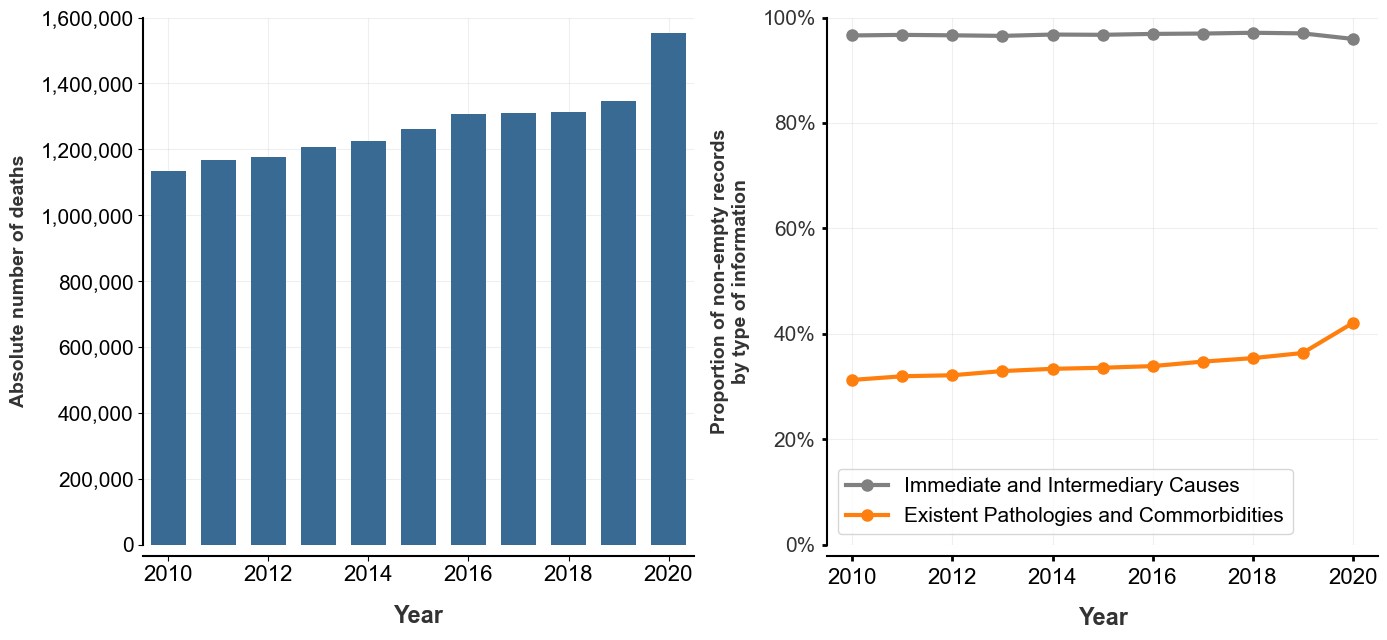

In [76]:
# -- total no estado
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,6.5))


bar_width=0.7
# -- plot data
ax1.bar(yy_list, total_arr, width=bar_width, zorder=2, label="Total", color="#396a93", alpha=1.0)
#ax1.bar(serie_obito_neo['ANO_OBITO']+0.2, serie_obito_neo['count'], width=bar_width, zorder=2, label="Total", color="#396a93", alpha=1.0)

ax2.plot(yy_list, linhaa_arr, zorder=4, color="#808080", linewidth=3, marker='o', ms=8, label="Immediate and Intermediary Causes")
#ax2.plot(yy_list, linhab_arr, zorder=4, color="#2b506e", linewidth=3, marker='o', ms=8, label="LINHAB")
#ax2.plot(yy_list, linhac_arr, zorder=4, color="#ff4d4d", linewidth=3, marker='o', ms=8, label="LINHAC")
#ax2.plot(yy_list, linhad_arr, zorder=4, color="#808080", linewidth=3, marker='o', ms=8, label="LINHAD")
ax2.plot(yy_list, linha2_arr, zorder=4, color="tab:orange", linewidth=3, marker='o', ms=8, label="Existent Pathologies and Commorbidities")
#ax1.plot(serie_colon['ANO_OBITO'], serie_colon['Taxa de Mortalidade'], zorder=4, color="#990000", linewidth=3, marker='o', ms=8, label="Cólon (C18)")
#ax1.plot(serie_figado['ANO_OBITO'], serie_figado['Taxa de Mortalidade'], zorder=4, color="#333333", linewidth=3, marker='o', ms=8, label="Fígado (C22)")


# -- ticks and labels
ax1.set_xlabel("Year", fontsize=17, weight='bold', labelpad=14, fontdict={'color': "#333333"})
ax2.set_xlabel("Year", fontsize=17, weight='bold', labelpad=14, fontdict={'color': "#333333"})
ax1.set_ylabel("Absolute number of deaths", fontsize=14, weight='bold', fontdict={'color': "#333333"}, labelpad=9)
ax2.set_ylabel("Proportion of non-empty records\nby type of information", fontsize=14, weight='bold', fontdict={'color': "#333333"}, labelpad=9)
ax1.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
#ax1_twin.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
#ax1_twin.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
#ax1_twin.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',').replace(",", ".")))

ax1.set_ylim([0, 1600000])
ax2.set_ylim([0, 100])


ax2.tick_params(width=2, labelsize=15, pad=5)
#ax1_twin.tick_params(width=2, labelsize=15, pad=5)
#ax1.yaxis.set_tick_params(labelsize=15)
#ax1.xaxis.set_tick_params(labelsize=16)
#ax1_twin.yaxis.set_tick_params(labelsize=15)

# -- spines
for axis in [ax1, ax2]:
    for i in ['left', 'right', 'bottom', 'top']:
        axis.spines[i].set_linewidth(1.5)

    axis.spines['top'].set_linewidth(0)
    axis.spines['right'].set_linewidth(0)
    axis.spines['bottom'].set_position(('outward', 8))
    axis.set_xlim([2009.5, 2020.5])

    axis.yaxis.set_tick_params(labelsize=15)
    axis.xaxis.set_tick_params(labelsize=16)

    axis.grid(alpha=0.2, zorder=0)

#serie_data = serie_obito_neo
#serie_sum = serie_obito_neo['count'].sum()
#for idx in range(len(serie_data)):
#    porc = (serie_data['count'].iat[idx]/serie_sum)*100
#    print(porc, idx, serie_data['count'].iat[idx])
#
#    ax1.text(x=serie_data['ANO_OBITO'].iat[idx]+0.09, y=serie_data['count'].iat[idx]*1.25, s=f'{serie_data["count"].iat[idx]:,}'.replace(",", "."), 
#                ha='left', rotation=90, fontsize=18, color="#396a93", weight='bold')

#ax1.set_xticks([n for n in serie_estomago["ANO_OBITO"].tolist()])
ax2.set_yticklabels([f'{x.get_text()}%' for x in ax2.get_yticklabels()], weight='normal', color="#333333")
ax2.legend(loc=3, prop={'size':15})

#ax1_twin.legend(prop={'size':16}, loc=2)
fig.tight_layout()
#fig.savefig(os.path.join(basepath, "opas", "neoplasias", "figs", "txmort_neoplasias_tipo.png"), dpi=300, bbox_inches='tight')
#fig.savefig(os.path.join(basepath, "opas", "sim", "figs", "obitos_all_2013_2023.png"), dpi=300, bbox_inches='tight')
#fig.savefig(os.path.join(basepath, "opas", "sim", "figs", "obitos_all_2013_2023.pdf"), dpi=300, bbox_inches='tight')

**Frequency of basic cause and existent pathologies**

In [77]:
yy_list = [ year for year in range(2010, 2021) ]
base_dict = {'TOTAL': np.nan, 'LINHAA': np.nan, 'LINHAB': np.nan, 'LINHAC': np.nan, 'LINHAD': np.nan, 
             'LINHAII': np.nan, 'FREQ.CAUSABAS': np.nan, 'FREQ.LINHAII': np.nan }
rec_years = { yy: dict(base_dict) for yy in range(2010, 2021) }

for yy in yy_list:
    print(yy)
    query = sim_query(yy)
    cur_df = query_data(query, 'sim', engine)

    rec_years[yy]['TOTAL'] = cur_df.shape[0]
    rec_years[yy]['LINHAA'] = cur_df["LINHAA"].notnull().sum()
    rec_years[yy]['LINHAB'] = cur_df["LINHAB"].notnull().sum()
    rec_years[yy]['LINHAC'] = cur_df["LINHAC"].notnull().sum()
    rec_years[yy]['LINHAD'] = cur_df["LINHAD"].notnull().sum()
    rec_years[yy]['LINHAII'] = cur_df["LINHAII"].notnull().sum()
    rec_years[yy]["FREQ.CAUSABAS"] = format_column(cur_df, "CAUSABAS")
    rec_years[yy]["FREQ.LINHAII"] = format_column(cur_df, "LINHAII")

2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


In [84]:
base_dict2 = {"CAUSABAS": np.nan, "LINHAII": np.nan}
counting_causes = { yy: dict(base_dict2) for yy in range(2010, 2021) }
for yy in yy_list:
    causes_list = pd.Series([ item for sublist in rec_years[yy]["FREQ.CAUSABAS"] for item in sublist ]).value_counts().reset_index().rename({"index": "ICD-10", 'count': 'frequency'}, axis=1)
    linha2_list = pd.Series([ item for sublist in rec_years[yy]["FREQ.LINHAII"] for item in sublist ]).value_counts().reset_index().rename({"index": "ICD-10", 'count': 'frequency'}, axis=1)
    
    counting_causes[yy]["CAUSABAS"] = causes_list
    counting_causes[yy]["LINHAII"] = linha2_list

In [89]:
for yy in yy_list:
    causa_df = counting_causes[yy]["CAUSABAS"]
    linha_df = counting_causes[yy]["LINHAII"]
    causa_df["%"] = (causa_df["frequency"]/causa_df["frequency"].sum())*100
    linha_df["%"] = (linha_df["frequency"]/linha_df["frequency"].sum())*100

    counting_causes[yy]["CAUSABAS"] = causa_df
    counting_causes[yy]["LINHAII"] = linha_df

In [107]:
cid_df = pd.read_csv(basefolder.parent.joinpath("sim", "codes.csv"), delimiter=',', names=[1, 2, 3, 4, 5, 6])
cid_df['code'] = cid_df[1].apply(lambda x: x[:3])
cid_df['description'] = cid_df[6].copy()

cid_df1 = cid_df.drop_duplicates(subset='code')[['code', 'description']]
cid_description = dict(zip(cid_df1['code'], cid_df1['description']))
cid_description

{'A00': 'Cholera',
 'A01': 'Typhoid fever',
 'A02': 'Other salmonella infections',
 'A03': 'Shigellosis',
 'A04': 'Other bacterial intestinal infections',
 'A05': 'Other bacterial foodborne intoxications, not elsewhere classified',
 'A06': 'Amebiasis',
 'A07': 'Other protozoal intestinal diseases',
 'A08': 'Viral and other specified intestinal infections',
 'A09': 'Infectious gastroenteritis and colitis, unspecified',
 'A15': 'Respiratory tuberculosis',
 'A17': 'Tuberculosis of nervous system',
 'A18': 'Tuberculosis of bones and joints',
 'A19': 'Miliary tuberculosis',
 'A20': 'Plague',
 'A21': 'Tularemia',
 'A22': 'Anthrax',
 'A23': 'Brucellosis',
 'A24': 'Glanders and melioidosis',
 'A25': 'Rat-bite fevers',
 'A26': 'Erysipeloid',
 'A27': 'Leptospirosis',
 'A28': 'Other zoonotic bacterial diseases, not elsewhere classified',
 'A30': "Leprosy [Hansen's disease]",
 'A31': 'Infection due to other mycobacteria',
 'A32': 'Listeriosis',
 'A33': 'Tetanus neonatorum',
 'A34': 'Obstetrical te

In [108]:
outputfolder = basefolder.joinpath("causas_comorbidades_sim.xlsx")

with pd.ExcelWriter(outputfolder) as writer:
    for yy in yy_list:
        causa_df = counting_causes[yy]["CAUSABAS"]
        linha_df = counting_causes[yy]["LINHAII"]
        causa_df['description'] = causa_df['ICD-10'].map(cid_description)
        linha_df['description'] = linha_df['ICD-10'].map(cid_description)
        causa_df.to_excel(writer, sheet_name=f'causabas_{yy}', index=False)
        linha_df.to_excel(writer, sheet_name=f'comorbidades_{yy}', index=False)

## **Apriori Algorithm - Spatial**

In [45]:
def format_column(sim_df, col):
    subset_df = sim_df[col].copy()
    subset_lst = subset_df.apply(lambda x: list(x), axis=1).tolist()
    formatted_rows = []
    for current_list in subset_lst:
        new_el = []
        for element in current_list:
            if pd.notna(element):
                cur = [ el for el in element.strip().split("*") if el!='' ]
                new_el += cur
        formatted_rows.append([ el[:3] for el in  new_el ] )
    formatted_rows = [ elem for elem in formatted_rows if elem ]
    return formatted_rows

In [38]:
sim_query = lambda year: f''' SELECT 
        CHAVE_CONTADOR_FONTE, CODMUNRES, DTOBITO, 
        SUBSTR(CAUSABAS, 1, 3) AS CAUSABAS, LINHAA, LINHAB, LINHAC, 
        LINHAD, LINHAII
    FROM
        sim
    WHERE DTOBITO >= '{year}-01-01' AND DTOBITO <= '{year}-12-31' '''


df = []
for year in range(2010, 2013):
    q = sim_query(year)
    cur_df = query_data(q, engine)
    # -- have listed a commorbidities or existent pathology
    cur_df = cur_df[(pd.notna(cur_df["LINHAII"]))].copy()
    df.append(cur_df)
df = pd.concat(df)


#q2010 = sim_query(2010)
#q2011 = sim_query(2011)
#q2012 = sim_query(2012)
#q2013 = sim_query(2013)
#
#df_2011 = query_data(q2011, engine)
#df_2016 = query_data(q2016, engine)
#df_2020 = query_data(q2020, engine)

In [39]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1105761 entries, 75 to 1178007
Data columns (total 9 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   CHAVE_CONTADOR_FONTE  1105761 non-null  object
 1   CODMUNRES             1105761 non-null  object
 2   DTOBITO               1105761 non-null  object
 3   CAUSABAS              1105761 non-null  object
 4   LINHAA                1051615 non-null  object
 5   LINHAB                904670 non-null   object
 6   LINHAC                601464 non-null   object
 7   LINHAD                314655 non-null   object
 8   LINHAII               1105761 non-null  object
dtypes: object(9)
memory usage: 84.4+ MB
None


,CHAVE_CONTADOR_FONTE,CODMUNRES,DTOBITO,CAUSABAS,LINHAA,LINHAB,LINHAC,LINHAD,LINHAII
75,76DOAC2010,120034,2010-12-25 00:00:00.000000,I21,*I219,*I509,*I429,*I10X,*A309
142,143DOAC2010,120040,2010-02-04 00:00:00.000000,J44,*J960,*N390,*J449,None,*I10X
143,144DOAC2010,120040,2010-02-21 00:00:00.000000,J44,*R092,*J189,*J449,*E149,*I10X
145,146DOAC2010,120040,2010-06-19 00:00:00.000000,J20,*R092,*J209,None,None,*I10X*M329
323,324DOAC2010,120005,2010-11-19 00:00:00.000000,C22,*K254,*R18X,*C229,*K229,*K746


In [46]:
df_temp = df[(pd.notna(df["LINHAII"]))].copy()
count_mun = df_temp["CODMUNRES"].value_counts().reset_index()
list_of_mun = count_mun[count_mun['count']>=100]["CODMUNRES"]
df_temp = df_temp[df_temp["CODMUNRES"].isin(list_of_mun)]
#rows_linha2 = format_column(df_temp, ["CAUSABAS", "LINHAII"])

In [53]:
mun_lists = dict()

for mun in list_of_mun:
    filter_df = df_temp[df_temp["CODMUNRES"]==mun].copy()
    fmt_cause = format_column(filter_df, ["CAUSABAS", "LINHAII"])
    mun_lists.update({mun: fmt_cause})

In [80]:
mun_apriori = dict()

for mun in list_of_mun:
    copresences_mun = mun_lists[mun]
    te = TransactionEncoder()
    te_ary = te.fit(copresences_mun).transform(copresences_mun)
    temp_df = pd.DataFrame(te_ary, columns=te.columns_)
    res = apriori(temp_df, min_support=0.001, use_colnames=True)
    mun_apriori.update({mun: res})


In [81]:
mun_apriori.keys()

dict_keys(['355030', '330455', '310620', '230440', '292740', '261160', '431490', '530010', '410690', '350950', '520870', '351880', '130260', '150140', '330490', '354340', '500270', '354780', '250750', '330170', '354850', '260790', '330330', '330350', '354870', '353440', '270430', '240810', '411370', '211130', '330390', '311860', '313670', '352590', '280030', '260960', '355220', '351620', '354980', '317020', '354990', '330100', '510340', '221100', '353060', '431440', '420910', '317010', '350600', '430460', '430510', '291080', '355100', '355410', '420540', '330510', '520140', '261070', '352900', '330630', '260410', '353870', '320520', '411520', '351380', '352690', '520110', '354100', '310670', '354880', '320130', '431690', '320500', '352940', '320530', '330045', '411990', '350320', '110020', '430920', '350570', '312770', '315460', '430060', '420240', '355280', '314330', '432300', '230370', '354390', '351300', '350160', '420460', '354140', '410480', '260290', '353070', '431560', '355250',

In [89]:
ex = mun_apriori['355030']
ex[ex["support"]<=0.002][-30:]

,support,itemsets
411,0.001417,"(I69, R54)"
412,0.001253,"(I71, I70)"
414,0.001571,"(J44, I70)"
415,0.001060,"(J18, I73)"
416,0.001263,"(J18, J44)"
417,0.001070,"(K70, J18)"
420,0.001118,"(J18, K92)"
421,0.001195,"(J18, L89)"
427,0.001956,"(J18, R64)"
430,0.001484,"(N19, J44)"


## **SIH Networks**

In [68]:
basefolder = Path.home().joinpath("Documents", "data", "opendatasus")
dbname = "SIH_CNES_WAREHOUSE.db"

In [69]:
engine = create_engine(f'sqlite:///'+str(basefolder.joinpath(dbname)))

In [70]:
# -- test

def query_metadata(engine):
    inspector = inspect(engine)
    tables = inspector.get_table_names()
    table_dict = { table_name : inspector.get_columns(table_name) for table_name in tables }
    return table_dict


def query_data(query_str, engine, batchsize=1000):

    schema_data = {
        'rows': [],
        'columns': [],
    }

    with engine.connect() as conn:
        qres = conn.execute(query_str)
        schema_data['columns'] = list(qres.keys())

        while True:
            rows = qres.fetchmany(batchsize)
            if not rows:
                break
            schema_data["rows"] += [ row for row in rows ]
    
    res_df = pd.DataFrame(schema_data['rows'], columns=schema_data['columns'])
    return res_df

In [89]:
def select_period_aih(engine, start_date, final_date, diag_level=0):
    '''
        ...
    '''
    if diag_level>4:
        diag_level = 4
    elif diag_level<0:
        diag_level = 0
    
    query = f'''
        SELECT 
            N_AIH, CNES, MUNIC_RES, MUNIC_MOV,
            SUBSTR(DIAG_PRINC,1,{diag_level}) as DIAG_CATEG 
        FROM aih_reduzida
        WHERE DT_INTER >= '{start_date.strftime("%Y-%m-%d")}' AND DT_INTER <= '{final_date.strftime("%Y-%m-%d")}'
    '''
    df = query_data(query, engine)
    return df

def select_period_servicos(engine, start_date, final_date, proc_level=6):
    '''
        ...
    '''
    query = f'''
        SELECT
            *
        FROM (
            SELECT 
                a.SP_NAIH, a.SP_CNES, a.SP_ATOPROF, 
                b.MUNIC_RES, b.MUNIC_MOV, b.DT_INTER
            FROM servicos_profissionais a
            LEFT JOIN aih_reduzida b
            ON a.SP_NAIH = b.N_AIH
        )
        WHERE DT_INTER >= '{start_date.strftime("%Y-%m-%d")}' AND DT_INTER <= '{final_date.strftime("%Y-%m-%d")}'
    '''
    df = query_data(query, engine)
    return df


def edgelist_for_citytocity(engine, start_date, final_date, diag_level):
    '''
        ...
    '''
    df = select_period_aih(engine, start_date, final_date, diag_level=diag_level)
    edgelist = df.groupby(["MUNIC_RES", "MUNIC_MOV"])["DIAG_CATEG"].value_counts().reset_index()
    edgelist = pd.pivot_table(edgelist, index=["MUNIC_RES", "MUNIC_MOV"], columns="DIAG_CATEG", values="count").fillna(0)
    edgelist["SOMA"] = edgelist.apply(sum, axis=1)
    return edgelist

def edgelist_for_citytohospital(engine, start_date, final_date, diag_level):
    '''
        ...
    '''
    df = select_period_aih(engine, start_date, final_date, diag_level=diag_level)
    edgelist = df.groupby(["MUNIC_RES", "CNES"])["DIAG_CATEG"].value_counts().reset_index()
    edgelist = pd.pivot_table(edgelist, index=["MUNIC_RES", "CNES"], columns="DIAG_CATEG", values="count").fillna(0)
    edgelist["SOMA"] = edgelist.apply(sum, axis=1)
    return edgelist

In [82]:
start_date, final_date = dt.datetime(2010,1,1), dt.datetime(2010,2,1)

df = select_period_aih(engine, start_date, final_date, diag_level=1)

In [83]:
df

,N_AIH,CNES,MUNIC_RES,MUNIC_MOV,DIAG_CATEG
0,2310100904265,2333899,230470,230470,O
1,2310100904276,2333899,230470,230470,O
2,2310100904287,2333899,230470,230470,O
3,2310100904298,2333899,230470,230470,O
4,2310100904309,2333899,230470,230470,O
...,...,...,...,...,...
40265,2310104444450,2526638,230440,230440,J
40266,2310104450511,2499363,230440,230440,O
40267,2310104538192,2526638,230440,230440,J
40268,2310104728646,2478161,230440,230440,S


In [90]:
start_date, final_date = dt.datetime(2010,1,1), dt.datetime(2010,2,1)

df = select_period_servicos(engine, start_date, final_date)

In [91]:
df

,SP_NAIH,SP_CNES,SP_ATOPROF,MUNIC_RES,MUNIC_MOV,DT_INTER
0,2310100905827,2552345,0305020021,230180,230180,2010-01-13 00:00:00.000000
1,2310100904012,2333899,0310010039,230470,230470,2010-01-22 00:00:00.000000
2,2310100904012,2333899,0301010145,230470,230470,2010-01-22 00:00:00.000000
3,2310100904012,2333899,0202031179,230470,230470,2010-01-22 00:00:00.000000
4,2310100904012,2333899,0310010039,230470,230470,2010-01-22 00:00:00.000000
...,...,...,...,...,...,...
300436,2310100083929,2480026,0303170077,230440,230440,2010-01-05 00:00:00.000000
300437,2310100083929,2480026,0303170077,230440,230440,2010-01-05 00:00:00.000000
300438,2310100083929,2480026,0303170077,230440,230440,2010-01-05 00:00:00.000000
300439,2310100065944,2529459,0303170093,231025,230440,2010-01-14 00:00:00.000000


In [96]:
edgelist = df.groupby(["MUNIC_RES", "MUNIC_MOV"])["SP_ATOPROF"].value_counts().reset_index()
edgelist = pd.pivot_table(edgelist, index=["MUNIC_RES", "MUNIC_MOV"], columns="SP_ATOPROF", values="count").fillna(0)

In [99]:
edgelist.values

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [84]:
edgelist = edgelist_for_citytocity(engine, start_date, final_date, diag_level=0)
edgelist

DIAG_CATEG              SOMA
MUNIC_RES MUNIC_MOV         
120040    230440     1     1
130260    230190     1     1
          230440     5     5
          231340     1     1
140010    230440     1     1
...                 ..   ...
355030    230730     1     1
410690    231330     1     1
430210    230440     2     2
510340    230440     1     1
          231330     1     1

[824 rows x 2 columns]

In [86]:
'' in edgelist.columns

True

In [74]:
edgelist.sort_values(by="SOMA", ascending=False)

DIAG_CATEG               A      B      C      D      E      F     G      H  \
MUNIC_RES MUNIC_MOV                                                          
230440    230440     675.0  260.0  515.0  326.0  148.0  495.0  99.0  200.0   
231290    231290      67.0   53.0   31.0   32.0   28.0   70.0   6.0    2.0   
230730    230730     144.0   11.0    8.0   23.0   22.0    0.0   4.0    1.0   
230420    230420      82.0   19.0    3.0   29.0   24.0   79.0   5.0    0.0   
230370    230370      16.0    5.0    6.0   20.0   25.0    0.0  12.0    0.0   
...                    ...    ...    ...    ...    ...    ...   ...    ...   
230840    230320       0.0    1.0    0.0    0.0    0.0    0.0   0.0    0.0   
          230440       0.0    0.0    0.0    0.0    0.0    0.0   0.0    0.0   
230850    230360       0.0    0.0    0.0    0.0    0.0    0.0   0.0    0.0   
          230420       0.0    0.0    0.0    0.0    0.0    0.0   0.0    0.0   
510340    231330       0.0    0.0    0.0    0.0    0.0    0.0   0.0    0.0   

DIAG_CATEG               I       J  ...      P     Q      R      S      T  \
MUNIC_RES MUNIC_MOV                 ...                                     
230440    230440     932.0  1182.0  ...  328.0  94.0  126.0  753.0  219.0   
231290    231290      85.0   109.0  ...   13.0   4.0   22.0   50.0   12.0   
230730    230730      41.0   144.0  ...   30.0   5.0   36.0   40.0   35.0   
230420    230420     108.0    83.0  ...   11.0   6.0    4.0   47.0   13.0   
230370    230370      12.0    63.0  ...   14.0   0.0    2.0   50.0   13.0   
...                    ...     ...  ...    ...   ...    ...    ...    ...   
230840    230320       0.0     0.0  ...    0.0   0.0    0.0    0.0    0.0   
          230440       0.0     0.0  ...    0.0   0.0    0.0    0.0    1.0   
230850    230360       0.0     0.0  ...    0.0   0.0    0.0    0.0    0.0   
          230420       0.0     0.0  ...    0.0   0.0    0.0    1.0    0.0   
510340    231330       0.0     0.0  ...    0.0   0.0    0.0    0.0    0.0   

DIAG_CATEG             W    X    Y      Z     SOMA  
MUNIC_RES MUNIC_MOV                                 
230440    230440     0.0  0.0  4.0  397.0  11330.0  
231290    231290     0.0  0.0  0.0   31.0   1093.0  
230730    230730     0.0  0.0  0.0    6.0   1048.0  
230420    230420     0.0  0.0  0.0    5.0    865.0  
230370    230370     0.0  0.0  0.0   41.0    703.0  
...                  ...  ...  ...    ...      ...  
230840    230320     0.0  0.0  0.0    0.0      1.0  
          230440     0.0  0.0  0.0    0.0      1.0  
230850    230360     0.0  0.0  0.0    0.0      1.0  
          230420     0.0  0.0  0.0    0.0      1.0  
510340    231330     0.0  0.0  0.0    0.0      1.0  

[824 rows x 25 columns]

In [75]:
edges = [(src, tgt, attr.to_dict()) for (src, tgt), attr in edgelist.iterrows()]

In [77]:
g = nx.DiGraph()
g.add_edges_from(edges)

In [79]:
for edge in g.edges(data=True):
    print(edge)

('120040', '230440', {'A': 1.0, 'B': 0.0, 'C': 0.0, 'D': 0.0, 'E': 0.0, 'F': 0.0, 'G': 0.0, 'H': 0.0, 'I': 0.0, 'J': 0.0, 'K': 0.0, 'L': 0.0, 'M': 0.0, 'N': 0.0, 'O': 0.0, 'P': 0.0, 'Q': 0.0, 'R': 0.0, 'S': 0.0, 'T': 0.0, 'W': 0.0, 'X': 0.0, 'Y': 0.0, 'Z': 0.0, 'SOMA': 1.0})
('230440', '230350', {'A': 0.0, 'B': 0.0, 'C': 0.0, 'D': 0.0, 'E': 0.0, 'F': 0.0, 'G': 0.0, 'H': 0.0, 'I': 0.0, 'J': 0.0, 'K': 0.0, 'L': 0.0, 'M': 0.0, 'N': 0.0, 'O': 1.0, 'P': 0.0, 'Q': 0.0, 'R': 0.0, 'S': 0.0, 'T': 0.0, 'W': 0.0, 'X': 0.0, 'Y': 0.0, 'Z': 0.0, 'SOMA': 1.0})
('230440', '230370', {'A': 1.0, 'B': 0.0, 'C': 0.0, 'D': 0.0, 'E': 0.0, 'F': 0.0, 'G': 0.0, 'H': 0.0, 'I': 0.0, 'J': 0.0, 'K': 1.0, 'L': 0.0, 'M': 0.0, 'N': 0.0, 'O': 12.0, 'P': 0.0, 'Q': 0.0, 'R': 0.0, 'S': 4.0, 'T': 2.0, 'W': 0.0, 'X': 0.0, 'Y': 0.0, 'Z': 0.0, 'SOMA': 20.0})
('230440', '230428', {'A': 0.0, 'B': 0.0, 'C': 0.0, 'D': 0.0, 'E': 0.0, 'F': 0.0, 'G': 0.0, 'H': 0.0, 'I': 0.0, 'J': 0.0, 'K': 0.0, 'L': 0.0, 'M': 0.0, 'N': 1.0, 'O': 4.0

In [81]:
print(g.nodes())

['120040', '230440', '130260', '230190', '231340', '140010', '140047', '150080', '150140', '230940', '172100', '230360', '210140', '210637', '210860', '211130', '220027', '230420', '220202', '230410', '220209', '220545', '230523', '220720', '221040', '221093', '221100', '231290', '221120', '230010', '230250', '230840', '230015', '230765', '230770', '231160', '230020', '230425', '230030', '230550', '231135', '230040', '231330', '230050', '230060', '230070', '230760', '230075', '230640', '230080', '230090', '230370', '231070', '230100', '230350', '230428', '230625', '230110', '230535', '231180', '230120', '230210', '230125', '230130', '230730', '230140', '230150', '230160', '230170', '230180', '230540', '230570', '231400', '230185', '231130', '230195', '230200', '230830', '230205', '230260', '230220', '230230', '230780', '230240', '230280', '230270', '230740', '230290', '230300', '230310', '230900', '230320', '230330', '230340', '231230', '230365', '231220', '230380', '230390', '230393',